<a href="https://colab.research.google.com/github/Xazkiel0/cnn-dicoding-submission/blob/main/Dogs_vs_Cats_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'msayidulikhsanulya'
os.environ['KAGGLE_KEY'] = '70011aa7c74e4a852d2fe68014306fd7'

In [ ]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

100% 785M/788M [00:07<00:00, 125MB/s]
100% 788M/788M [00:07<00:00, 116MB/s]


In [ ]:
!rm -rf '/content/extracted/'

In [ ]:
import zipfile

zip_path = '/content/microsoft-catsvsdogs-dataset.zip'
extract_path = '/content/extracted/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
workdir = os.path.join(extract_path,'PetImages')
dataset_images_fold = os.listdir(workdir)
dataset_images_fold

['Dog', 'Cat']

In [ ]:
lowest_imgs_len = min([len(os.listdir(os.path.join(workdir,_label))) for _label in dataset_images_fold])
lowest_imgs_len

12501

**Mengambil gambar dari folder untuk diambil beberapa dan dimasukan ke dalam dataframe**

*Mengambil total 14000 data gambar dari 2 class*

In [ ]:
list_imgs = []
list_labels = []

for _label in dataset_images_fold:
  _path = os.path.join(workdir,_label)
  _imgs = os.listdir(_path)
  if len(_imgs) >= lowest_imgs_len:
    _imgs = _imgs[:lowest_imgs_len]

  list_imgs.extend(map(lambda x: os.path.join(_path,x),_imgs))
  list_labels.extend([_label for _ in _imgs])

df = pd.DataFrame({'filename':list_imgs,'class':list_labels})
df.head()

,filename,class
0,/content/extracted/PetImages/Dog/8879.jpg,Dog
1,/content/extracted/PetImages/Dog/8157.jpg,Dog
2,/content/extracted/PetImages/Dog/4192.jpg,Dog
3,/content/extracted/PetImages/Dog/6075.jpg,Dog
4,/content/extracted/PetImages/Dog/3451.jpg,Dog


In [ ]:
from PIL import Image

def is_valid_image(file_path):
    try:
        Image.open(file_path).verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        return False

In [ ]:
df['isvalid'] = df.filename.map(is_valid_image)
df.isvalid.value_counts()

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Invalid image: /content/extracted/PetImages/Dog/Thumbs.db - cannot identify image file '/content/extracted/PetImages/Dog/Thumbs.db'
Invalid image: /content/extracted/PetImages/Dog/11702.jpg - cannot identify image file '/content/extracted/PetImages/Dog/11702.jpg'
Invalid image: /content/extracted/PetImages/Cat/Thumbs.db - cannot identify image file '/content/extracted/PetImages/Cat/Thumbs.db'
Invalid image: /content/extracted/PetImages/Cat/666.jpg - cannot identify image file '/content/extracted/PetImages/Cat/666.jpg'


True     24998
False        4
Name: isvalid, dtype: int64

In [ ]:
df_clean = df[df.isvalid == True]
df_clean.isvalid.value_counts()

True    24998
Name: isvalid, dtype: int64

In [ ]:
import re

def filter_file_names(path):
  pattern = re.compile(r'/content/extracted/PetImages/(Cat|Dog)/')

  result = pattern.sub('', path)
  file_name = os.path.basename(result)

  file_extension = os.path.splitext(file_name)[1]
  return file_extension

In [ ]:
files_name_ext = df_clean.filename.map(filter_file_names)
files_name_ext.unique()

array(['.jpg'], dtype=object)

In [ ]:
df_clean.describe()

,filename,class,isvalid
count,24998,24998,24998
unique,24998,2,1
top,/content/extracted/PetImages/Dog/8879.jpg,Dog,True
freq,1,12499,24998


In [ ]:
df_clean.count()

filename    24998
class       24998
isvalid     24998
dtype: int64

In [ ]:
df_clean.groupby('class').count()

,filename,isvalid
class,,
Cat,12499,12499
Dog,12499,12499


(480, 448, 3)
(299, 351, 3)
(334, 500, 3)
(500, 364, 3)
(312, 450, 3)
(231, 500, 3)


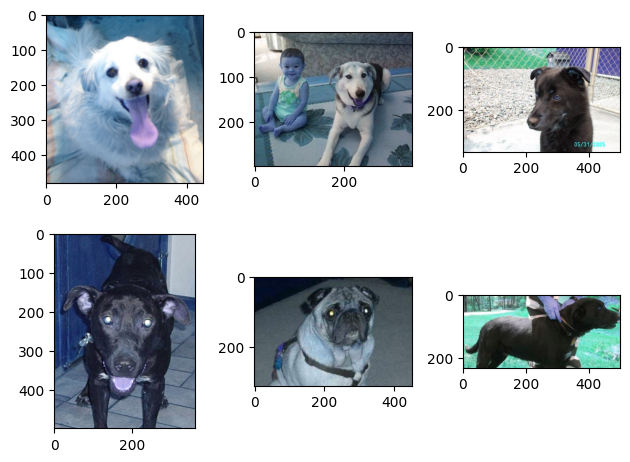

In [ ]:
# @title Default title text
import cv2

plt.subplot(231)
smple_img = cv2.imread(df_clean.filename[0])
print(smple_img.shape)
plt.imshow(smple_img)
plt.subplot(232)
smple_img = cv2.imread(df_clean.filename[123])
print(smple_img.shape)
plt.imshow(smple_img)
plt.subplot(233)
smple_img = cv2.imread(df_clean.filename[256])
print(smple_img.shape)
plt.imshow(smple_img)
plt.subplot(234)
smple_img = cv2.imread(df_clean.filename[56])
print(smple_img.shape)
plt.imshow(smple_img)
plt.subplot(235)
smple_img = cv2.imread(df_clean.filename[899])
print(smple_img.shape)
plt.imshow(smple_img)
plt.subplot(236)
smple_img = cv2.imread(df_clean.filename[2639])
print(smple_img.shape)
plt.imshow(smple_img)
plt.tight_layout()

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
training_from_gen = ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip=True,
    shear_range=.2,
    fill_mode = 'nearest',
    validation_split=.2,
    preprocessing_function=preprocess_input,
)

validation_from_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2,
)

In [ ]:
PX = 128
KERNEL_CONV = (3,3)
IMAGE_SIZE = (PX,PX)
INPUT_SIZE = (PX,PX,3)

In [ ]:
train_imgs = training_from_gen.flow_from_dataframe(
    df_clean,
    subset="training",
    target_size=IMAGE_SIZE,
    batch_size=8,
    color_mode='rgb',
    save_format='png',
    class_mode="binary",
)
test_imgs = validation_from_gen.flow_from_dataframe(
    df_clean,
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=8,
    color_mode='rgb',
    save_format='png',
    class_mode="binary",
)

Found 19999 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [ ]:
train_imgs.class_indices

{'Cat': 0, 'Dog': 1}

In [ ]:
from tensorflow.keras.applications import MobileNetV2
numclass_dataset = len(df['class'].unique())
numclass_dataset

2

In [ ]:
model = tf.keras.models.Sequential()
model.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SIZE))

model.add(layers.Conv2D(128, KERNEL_CONV, strides=1,padding='same', activation='relu'))
model.add(layers.SpatialDropout2D(.2))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, KERNEL_CONV,padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))

model.add(layers.Dense(1, activation='sigmoid'))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(metrics=['acc'],loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.003))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         1474688   
                                                                 
 spatial_dropout2d (Spatial  (None, 4, 4, 128)         0         
 Dropout2D)                                                      
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          73792     
                                                        

In [ ]:
from tensorflow.keras.callbacks import Callback
class ReachExpect(Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs['acc'] > .98 and logs['val_acc'] > .92:
      self.model.stop_training = True

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, mode='min')

history = model.fit(train_imgs,epochs=200,validation_data=test_imgs, callbacks=[reduce_lr,ReachExpect()])

Epoch 1/200
2499/2500 [============================>.] - ETA: 0s - loss: 0.6917 - acc: 0.6058

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


2500/2500 [==============================] - 211s 71ms/step - loss: 0.6917 - acc: 0.6058 - val_loss: 0.9746 - val_acc: 0.0000e+00 - lr: 0.0030
Epoch 2/200
2500/2500 [==============================] - 174s 70ms/step - loss: 0.6327 - acc: 0.6527 - val_loss: 1.3942 - val_acc: 0.1356 - lr: 0.0030
Epoch 3/200
2500/2500 [==============================] - 178s 71ms/step - loss: 0.5822 - acc: 0.6996 - val_loss: 2.8812 - val_acc: 0.0446 - lr: 0.0030
Epoch 4/200
2500/2500 [==============================] - 187s 75ms/step - loss: 0.5191 - acc: 0.7500 - val_loss: 2.9692 - val_acc: 0.0802 - lr: 0.0030
Epoch 5/200
2500/2500 [==============================] - 175s 70ms/step - loss: 0.4476 - acc: 0.7978 - val_loss: 0.7769 - val_acc: 0.5641 - lr: 6.0000e-04
Epoch 6/200
2500/2500 [==============================] - 176s 70ms/step - loss: 0.4059 - acc: 0.8209 - val_loss: 1.4350 - val_acc: 0.0240 - lr: 6.0000e-04
Epoch 7/200
2500/2500 [==============================] - 176s 70ms/step - loss: 0.3800 - acc: 

In [ ]:
hist_df = pd.DataFrame(history.history)
plt.subplot(2,2,1)
hist_df.loss.plot()
hist_df.val_loss.plot(style='--')
plt.legend()
plt.subplot(2,2,2)
hist_df.acc.plot()
hist_df.val_acc.plot(style='--')
plt.legend()

In [ ]:
model.save('dogs_cats.h5')
# model.save('dogs_cats.keras')
# model.save('/content/dogs_cats')

In [ ]:
import requests

access_key = 'PDo7-cckCnpdaPx-i5zIM6YvMb_DlSrYAjsX2cj0pOw'
url = 'https://api.unsplash.com/search/photos'


def get_unsplash_img(query):
  params = {'query': query, 'client_id': access_key}
  response = requests.get(url, params=params)
  data = response.json()
  return [photo['urls']['small'] for photo in data['results']]


In [ ]:
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing import image

def get_img_from_url(url):
  _dt = requests.get(url)
  _dt = Image.open(BytesIO(_dt.content))
  return preprocc_img(_dt)


def preprocc_img(img):
  _img = img.resize((128, 128))
  _img_array = image.img_to_array(_img)
  _rescaled_img = _img_array * (1./255)
  _rescaled_img = np.expand_dims(_rescaled_img, axis=0)
  return _rescaled_img


In [ ]:
# !gdown "11_aAajSr2u9TvcjNVZwZfLBTQbtGbUSP" -O dogs_cats.h5

In [ ]:
dogcat_model = tf.keras.models.load_model('dogs_cats.h5')
dogcat_model

In [ ]:
dog_sample = get_unsplash_img('dog')
cat_sample = get_unsplash_img('cat')

In [ ]:
dog_dt_url = np.array([get_img_from_url(dog) for dog in dog_sample])
cat_dt_url = np.array([get_img_from_url(cat) for cat in cat_sample])
dog_dt_url = np.squeeze(dog_dt_url)
cat_dt_url = np.squeeze(cat_dt_url)

In [ ]:
dog_dt_url.shape,cat_dt_url.shape

In [ ]:
dog_preds = dogcat_model.predict(preprocess_input(dog_dt_url))

np.argmax(dog_preds, axis=1)

In [ ]:
cat_preds = dogcat_model.predict(preprocess_input(cat_dt_url))

np.argmax(cat_preds, axis=1)

In [ ]:
dog_real_dt = np.squeeze([preprocc_img(Image.open(_file)) for _file, _label, _ in df_clean[df_clean['class'] == "Dog"].sample(6).values])
cat_real_dt = np.squeeze([preprocc_img(Image.open(_file)) for _file, _label, _ in df_clean[df_clean['class'] == "Cat"].sample(6).values])

In [ ]:
mix_dt = np.concatenate((dog_real_dt,cat_real_dt))
for i,_img_arr in enumerate(mix_dt,start=1):
  plt.subplot(2,len(mix_dt)//2,i)
  plt.imshow(_img_arr)

In [ ]:
dog_real_preds = dogcat_model.predict(dog_real_dt)

np.argmax(dog_real_preds, axis=1)

In [ ]:
cat_real_preds = dogcat_model.predict(cat_real_dt)

np.argmax(cat_real_preds, axis=1)

In [ ]:
dt1 = Image.open("/content/extracted/PetImages/Cat/0.jpg")
predictions = dogcat_model.predict(preprocc_img(dt1))

np.argmax(predictions, axis=1)

In [ ]:
model_dir = os.path.join('/content','dogs_cats.keras')

In [ ]:
model_loaded = tf.keras.models.load_model(model_dir)